In [9]:
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras import layers 
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv2D, Activation, MaxPooling2D, Dropout, Flatten

import tensorflow_addons as tfa
import cv2
import os 
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import datetime

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import mean_absolute_error
import random 
import math
import time
import pandas as pd

import main
import dataset_generator

In [3]:
base_models_path = 'C:/Users/user/Desktop/models/child_skin_classification'
PATH = 'C:/Users/user/Desktop/datasets/Child Skin Disease'
# PATH = '../../datasets/Child Skin Disease'
dataset = os.path.join(PATH, 'Total_Dataset')
N_RES = 256

min_num = 100
max_num = 3000 
base_num = 1000 

name_dict = main.name_dict 
class_list = main.class_list

In [11]:
def create_all_dict(dataset_path, min_num, max_num):
    all_dict = dict() 
    count_all_dict = dict() 

    for i in range(10):
        folders = os.listdir(os.path.join(dataset_path, f'H{i}'))
        
        for folder in folders:
            imgs = glob(f'{dataset_path}/H{i}/{folder}/*.jpg')
            
            folder = folder.lower().replace(' ', '')

            # class 통합 관련 내용 변경
            if folder in main.name_dict: 
                folder = main.name_dict[folder]
                
            if folder not in main.class_list:
                print(f'WARNING!! NOT FOUND LABEL : {folder}')
            
            if folder not in count_all_dict:
                count_all_dict[folder] = len(imgs) 
            else:
                count_all_dict[folder] += len(imgs)

    new_count_dict = count_all_dict.copy()


    # 데이터 정제
    for key, val in count_all_dict.items():
        if val < min_num:
            del new_count_dict[key]

        if val > max_num:
            new_count_dict[key] = max_num
            

    idx_num = 0 
    for key, val in new_count_dict.items():
        # print(idx)
        all_dict[key] = idx_num 
        idx_num += 1 
        
        
    return all_dict, new_count_dict

all_dict, count_all_dict = create_all_dict(dataset, min_num, max_num)
num_classes = len(all_dict)


WARNING!! NOT FOUND LABEL : normal
WARNING!! NOT FOUND LABEL : normal
WARNING!! NOT FOUND LABEL : normal
WARNING!! NOT FOUND LABEL : normal
WARNING!! NOT FOUND LABEL : normal
WARNING!! NOT FOUND LABEL : normal
WARNING!! NOT FOUND LABEL : normal
WARNING!! NOT FOUND LABEL : normal
WARNING!! NOT FOUND LABEL : normal
WARNING!! NOT FOUND LABEL : normal


In [17]:
def create_test_list(dataset_path, all_dict, count_all_dict):
    images = []
    for i in range(7, 9):
        
        folders = os.listdir(os.path.join(dataset_path, f'H{i}'))
        
        for folder in folders:
            # folder = folder.lower().replace(' ', '')
            reg_folder = folder.lower().replace(' ', '') 
            if (reg_folder in all_dict) or (reg_folder in main.name_dict):
                img = glob(dataset_path + f'/H{str(i)}/{folder}/*.jpg')
                images.extend(img)
                


    # 고른 데이터 분배를 위한 random shuffle
    random.shuffle(images)

    test_images = []
    for idx_imgs, val_imgs in enumerate(images):

        # class 통합 관련 내용 변경
        # classes = val_imgs.split('/')[-2].lower().replace(' ', '')
        classes = val_imgs.split('/')[-1].split('\\')[0].lower().replace(' ', '')
        
        if classes in main.name_dict:
            classes = main.name_dict[classes]
        
        if count_all_dict[classes] > 0:
            count_all_dict[classes] -= 1
            test_images.append(val_imgs)
        
    test_labels = [] 
    for img in test_images:
        lbl = img.split('/')[-1].split('\\')[0].lower().replace(' ', '')
        # lbl = img.split('/')[-2].lower().replace(' ', '')
        # print(lbl)

        # 변경/통합 버전으로 label 처리
        if lbl in main.name_dict:
            lbl = main.name_dict[lbl]

        lbl = dataset_generator.label_2_index(lbl, all_dict)
        test_labels.append(lbl)
        
    test_images = np.reshape(test_images, [-1, 1])
    test_labels = np.reshape(test_labels, [-1, 1])
    
    
    return test_images, test_labels

In [19]:
test_images, test_labels = create_test_list(dataset, all_dict, count_all_dict)

In [35]:
def test_generator(images, labels):
    
    for img, lbl in zip(images, labels):
        
        img = img[0].decode('utf-8')
        
        img = cv2.imread(img)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (main.num_res, main.num_res))
        img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)

        yield (img, lbl)    
            
def create_dataset(images, labels, d_type='train', aug=False):
    
    # if d_type == 'test':
    return tf.data.Dataset.from_generator(test_generator, 
                                            output_types=(tf.float64, tf.float32), 
                                            output_shapes=(tf.TensorShape([main.num_res, main.num_res, 3]), tf.TensorShape([1])),
                                            args=[images, labels])
        
    # else:
    #     return tf.data.Dataset.from_generator(train_generator, 
    #                                           output_types=(tf.float64, tf.float32), 
    #                                           output_shapes=(tf.TensorShape([main.num_res, main.num_res, 3]), tf.TensorShape([1])),
    #                                           args=[images, labels, aug])

In [20]:
model = keras.models.load_model(os.path.join(base_models_path, '20220726','checkpoint_20220726-085206_efficientb4_kfold_5_0.h5'))


In [36]:
test_dataset = create_dataset(test_images, test_labels).batch(32)
test_dataset

<BatchDataset element_spec=(TensorSpec(shape=(None, 300, 300, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>

In [37]:
# Applying Normalized
model.evaluate(test_dataset)

257/257 [==============================] - 65s 253ms/step - loss: 3.7862 - accuracy: 0.3285


[3.786180019378662, 0.32850182056427]

In [33]:
# Not Applying Normalized
model.evaluate(test_dataset)

257/257 [==============================] - 77s 271ms/step - loss: 3.6109 - accuracy: 0.3406


[3.6109225749969482, 0.34056028723716736]

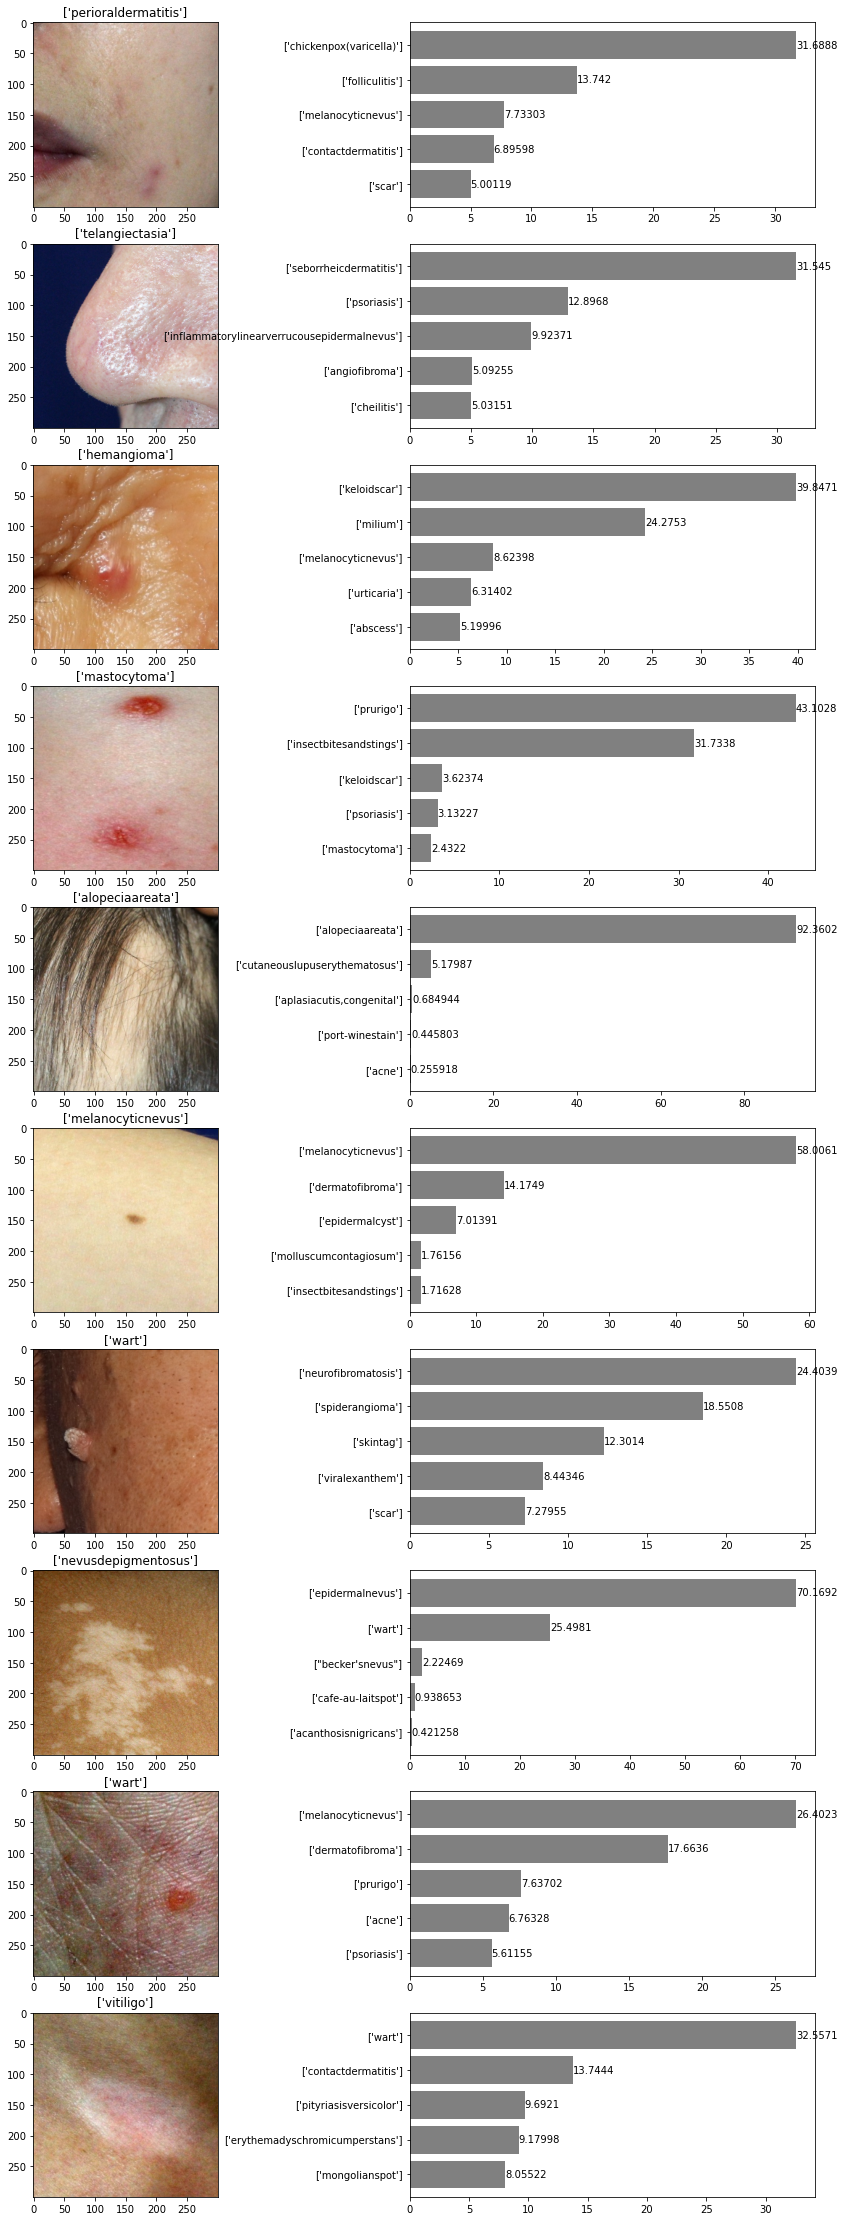

In [41]:
num = 10
fig, ax = plt.subplots(figsize=(16,40), ncols=2, nrows=num)
# test_dataset1 = test

row = 0 
for img, lbl in test_dataset.unbatch().take(10):
    ax[row, 0].imshow(img / 255.)
    ax[row, 0].set_title(dataset_generator.index_2_label(lbl, all_dict))
    
    logits = model.predict(img[tf.newaxis, ...])
    prediction = logits[0]
    
    # 가장 높은 확률의 예측값 5개를 뽑음
    # top_5_predict = prediction.argsort()[::-1][:5]
    top_5_predict = np.argsort(prediction)[::-1][:5]
    top_5_values = np.sort(prediction)[::-1][:5]
    
    # print(top_5_values)
    
    labels = [dataset_generator.index_2_label(index, all_dict)for index in top_5_predict]
    color = ['gray'] * 5
    color = color[::-1]
    hbars = ax[row, 1].barh(range(5), prediction[top_5_predict][::-1] * 100, color=color)
    ax[row, 1].set_yticks(range(5), labels[::-1])  
    ax[row, 1].bar_label(hbars)
    
    row += 1